## BERT Set

Initial work found in [this BERT Sentence Embedding tutorial](https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/#sentence-vectors)

In [1]:
import pickle

import nltk
import torch

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from tqdm import tqdm

from transformers import BertTokenizer, BertModel

from MulticoreTSNE import MulticoreTSNE as TSNE

from sklearn.metrics import classification_report, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

In [2]:
CLASS_DICT = dict(zip((1, 2, 3, 5, 7, 9, 11), 
                      ('real', 'fake', 'opinion', 'polarized', 'satire', 'promotional', 'correction')
                     )
                 )

def marked_text(input_sent):
    return "[CLS] " + input_sent + " [SEP]"

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [4]:
with open(f"../data/texts_labelled_sub100.pickle", mode='rb') as filein:
    texts = pickle.load(filein)

texts = texts[texts['text'] != '']

with open(f"../data/all_urls.pickle", mode='rb') as filein:
    urls = pickle.load(filein)

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True).to(device)

In [6]:
model.eval();

First, be sure to initialize `BertModel` with `output_hidden_states=True`

For each article:
* We call `nltk.sent_tokenize` on its scraped text,
* then we sandwich each sentence above between the `[CLS]` and `[SEP]` tags
* then we call `BertTokenizer.tokenize` on each sentence of the above,
* then we call `BertTokenizer.convert_tokens_to_ids` on each tokenized text above forming `indexed_tokens`,
* then we assign a segment ID of `1` to all of the tokens in each individual sentence, forming `segment_ids`
    * since we will be passing each sentence through without the objective of comparing them (they all come from the same document)
* then we convert both `indexed_tokens` and `segment_ids` into `torch.tensor`s
    * `x = torch.tensor([x])`
* then, for each pair of tokenized text and segment ID array, we run it through a forward pass in the pretrained `BertModel`
* then for each hidden state array extract the second to last item and average it on the vertical axis to form a 768-element "sentence embedding"
* finally, average all of the sentence embeddings for a particular article to form the "document embedding"
* when we have the full collection of document embeddings, we convert them using [this formula](https://stackoverflow.com/a/57942576):
    * first copy them all to the CPU
    * then convert them all to `numpy` arrays
    * finally construct a `pandas` DataFrame out of the above list

In [7]:
try:
    with open('../data/bert_embeddings_100.pickle', mode='rb') as filein:
        documents_cpu = pickle.load(filein)
except FileNotFoundError:
    documents = []
    for (_, row) in tqdm(texts.iterrows(), total=texts.shape[0]):
        if not row['text']:
            continue
        sents = nltk.sent_tokenize(row['text'])
        marked_sents = [marked_text(sentence) for sentence in sents]

        tokenized_text = [tokenizer.tokenize(sentence) for sentence in marked_sents]
        segments_ids = [[1] * len(sentence) for sentence in tokenized_text]
        indexed_tokens = [tokenizer.convert_tokens_to_ids(sentence) for sentence in tokenized_text]

        tokens_tensors = [torch.tensor([sentence], device=device) for sentence in indexed_tokens]
        segments_tensors = [torch.tensor([sentence], device=device) for sentence in segments_ids]
        sent_embeddings = []
        for sentence, segments in tuple(zip(tokens_tensors, segments_tensors)):
            with torch.no_grad():
                outputs = model(sentence, segments)
            hidden_states = outputs[2]
            token_vecs = hidden_states[-2][0]
            sentence_embedding = torch.mean(token_vecs, dim=0)
            sent_embeddings.append(sentence_embedding)
        document = torch.stack(sent_embeddings)
        documents.append(torch.mean(document, dim=0))
    documents_cpu = [embedding.cpu().numpy() for embedding in documents]
    with open('../data/bert_embeddings_100.pickle', mode='wb') as fileout:
        pickle.dump(documents_cpu, fileout)

In [8]:
bert_df = pd.DataFrame(documents_cpu, dtype='object')
bert_df['label'] = texts['label']

In [9]:
tsne_e = TSNE(init='random', n_jobs=-1).fit_transform(bert_df.drop('label', axis=1))
x, y = tsne_e[:,0], tsne_e[:,1]

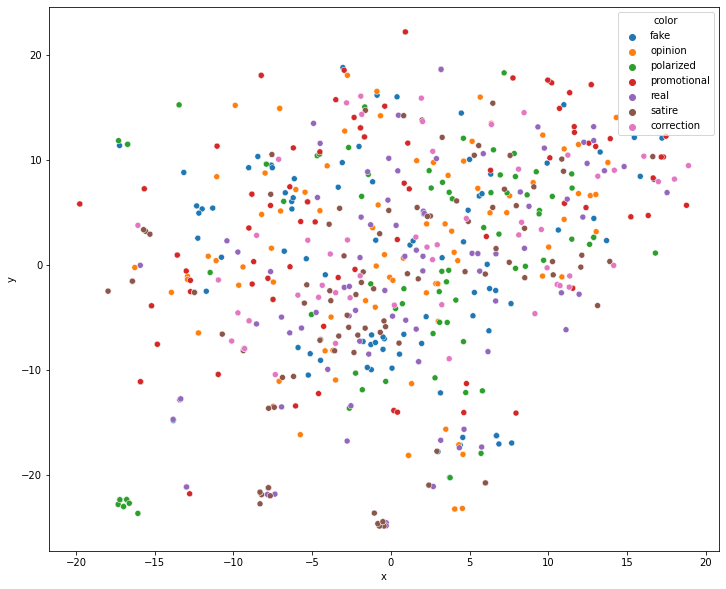

In [10]:
tsne_df = pd.DataFrame({'x':x, 'y':y, 'color':bert_df['label'].replace(CLASS_DICT)}, dtype='object')
_, ax = plt.subplots(figsize=(12, 10))
g = sns.scatterplot(x='x', y='y',
                    hue='color', legend='full',
                    data=tsne_df, ax=ax)